# سوال ۱۱

In [2]:
%cd drive/MyDrive/DataMining/hw3

/content/drive/MyDrive/DataMining/hw3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

sns.set_theme(style='whitegrid')

In [5]:
df = pd.read_csv('titanic.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop(['Cabin'], axis='columns', inplace=True)
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [7]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['Age'] = df.apply(lambda row: 'child' if row.Age < 10 else row.Sex, axis=1)
df.drop(['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Sex'], axis='columns', inplace=True)
df

,Survived,Pclass,Age,Fare,Embarked,FamilySize
0,0,3,male,7.2500,S,2
1,1,1,female,71.2833,C,2
2,1,3,female,7.9250,S,1
3,1,1,female,53.1000,S,2
4,0,3,male,8.0500,S,1
...,...,...,...,...,...,...
886,0,2,male,13.0000,S,1
887,1,1,female,30.0000,S,1
888,0,3,female,23.4500,S,4
889,1,1,male,30.0000,C,1


In [8]:
df_one_hotted = df.copy()
df_one_hotted['Pclass'] = df_one_hotted['Pclass'].map(str)
categorical_features = ['Pclass', 'Age', 'Embarked', 'FamilySize']
for column in categorical_features:
    dummies = pd.get_dummies(df_one_hotted[[column]])
    df_one_hotted = pd.concat([df_one_hotted, dummies], axis=1)
df_one_hotted.drop(categorical_features, axis=1, inplace=True)
df_one_hotted

,Survived,Fare,Pclass_1,Pclass_2,Pclass_3,Age_child,Age_female,Age_male,Embarked_C,Embarked_Q,Embarked_S
0,0,7.2500,0,0,1,0,0,1,0,0,1
1,1,71.2833,1,0,0,0,1,0,1,0,0
2,1,7.9250,0,0,1,0,1,0,0,0,1
3,1,53.1000,1,0,0,0,1,0,0,0,1
4,0,8.0500,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,13.0000,0,1,0,0,0,1,0,0,1
887,1,30.0000,1,0,0,0,1,0,0,0,1
888,0,23.4500,0,0,1,0,1,0,0,0,1
889,1,30.0000,1,0,0,0,0,1,1,0,0


In [9]:
X, y = df_one_hotted.drop('Survived', axis=1), df_one_hotted['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((623, 10), (268, 10))

In [10]:
grid_parameters = {
    'learning_rate': [1, 0.3, 0.1, 0.01, 0.001, 0.0001],
    'max_depth': range(2, 11),
    'reg_alpha': np.linspace(0, 50, 20),
}

grid_search = GridSearchCV(XGBClassifier(random_state=0), grid_parameters,
                           scoring='accuracy', verbose=10, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


GridSearchCV(estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [1, 0.3, 0.1, 0.01, 0.001, 0.0001],
                         'max_depth': range(2, 11),
                         'reg_alpha': array([ 0.        ,  2.63157895,  5.26315789,  7.89473684, 10.52631579,
       13.15789474, 15.78947368, 18.42105263, 21.05263158, 23.68421053,
       26.31578947, 28.94736842, 31.57894737, 34.21052632, 36.84210526,
       39.47368421, 42.10526316, 44.73684211, 47.36842105, 50.        ])},
             scoring='accuracy', verbose=10)

In [11]:
test_accuracy = grid_search.score(X_test, y_test)
print(f'Test accuracy = {test_accuracy:.3f}')
print('Best parameters:\n', grid_search.best_params_)

Test accuracy = 0.825
Best parameters:
 {'learning_rate': 0.01, 'max_depth': 3, 'reg_alpha': 2.6315789473684212}


In [12]:
y_pred = grid_search.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[146,  22],
       [ 25,  75]])

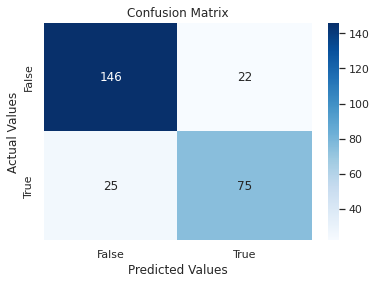

In [13]:
ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()